In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly
import plotly.express as px

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

# Análise exploratória dos dados

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

---

**Analisando os tipos de transações e a ocorrência de cada uma**

---



In [ ]:
df_count = df.type.value_counts()
df_count = pd.DataFrame(df_count).reset_index()
df_count.columns = ['type', 'amount']
fig = px.bar(df_count, x='type', y='amount',labels={'type':'Tipo de Transação', 'amount':'Quantidade'})
fig.update_layout(title_text='Tipos de Transações',width=800, height=600)

In [ ]:
#fig, axes = plt.subplots(figsize=(12,6))
#test = df.type.value_counts().plot(kind='bar', title='Tipo de Transações');



---
**Verificando se há valores faltando**

---




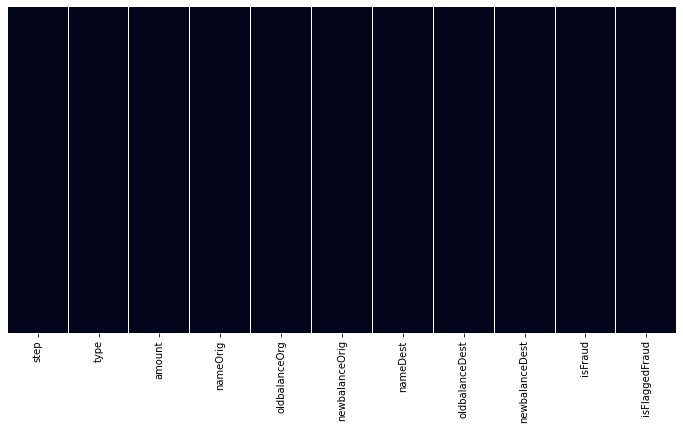

In [ ]:
 plt.figure(figsize=(12, 6))
 sns.heatmap(df.isnull(), yticklabels=False, cbar=False);

In [ ]:
df.dropna(inplace=True)

---
**Verificando a correlação entre as variáveis**

---

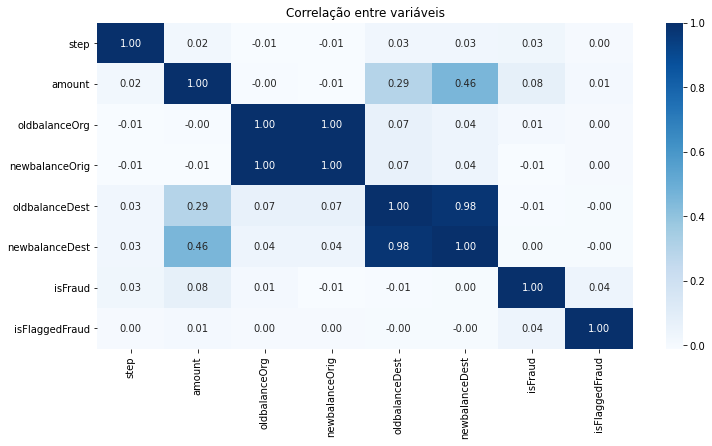

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot = True, fmt = '.2f', cmap='Blues')
plt.title('Correlação entre variáveis')
plt.show()

---

**Verificando a quantidade total de transações separadas por tipo e classificadas por fraude ou não**

---

In [ ]:
df.groupby(['type', 'isFraud']).size()

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
dtype: int64


---

**Outra forma de verificar**

---



In [ ]:
tipo = df['type']
print('Total', Counter(tipo))
tipos = ['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT']

for i in tipos:
  c = df[df['type'] == i]['isFraud']
  print('{} {}' .format(i, Counter(c)))

Total Counter({'CASH_OUT': 2237500, 'PAYMENT': 2151495, 'CASH_IN': 1399284, 'TRANSFER': 532909, 'DEBIT': 41432})
CASH_OUT Counter({0: 2233384, 1: 4116})
PAYMENT Counter({0: 2151495})
CASH_IN Counter({0: 1399284})
TRANSFER Counter({0: 528812, 1: 4097})
DEBIT Counter({0: 41432})


---

**As fraudes ocorrem nos tipos CASH_OUT e TRANSFER**

Verificando isso graficamente

---



In [ ]:
#df_count = df.groupby(['type', 'isFraud']).size()
#df_count = pd.DataFrame(df_count).reset_index()
#df_count.columns = ['type', 'isFraud','amount']
#fig = px.bar(df_count, x='type', y='amount', color='isFraud',labels={'type':'Tipo de Transação', 'isFraud':'Fraude', 'amount':'Quantidade'})
#fig.update_layout(title_text='Tipos de Transações',width=800, height=600)

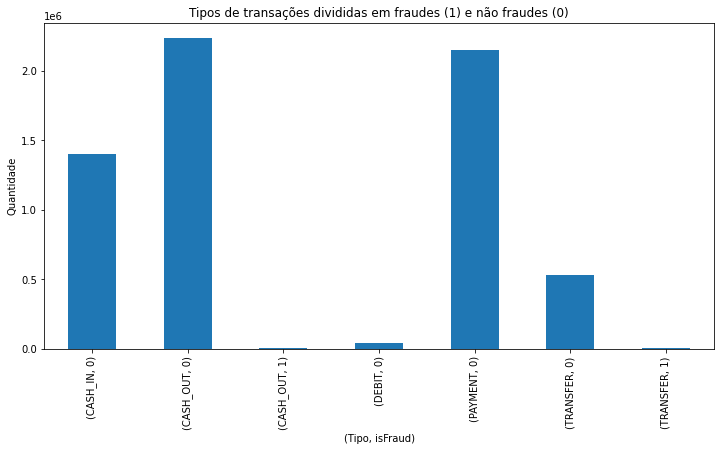

In [ ]:
fig, axes = plt.subplots(figsize=(12,6))
fig = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
fig.set_title('Tipos de transações divididas em fraudes (1) e não fraudes (0)')
fig.set_xlabel('(Tipo, isFraud)')
fig.set_ylabel('Quantidade');



---

**Analisando a quantidade de FlaggedFraud**

---



In [ ]:
df.groupby(['type', 'isFlaggedFraud']).size()

type      isFlaggedFraud
CASH_IN   0                 1399284
CASH_OUT  0                 2237500
DEBIT     0                   41432
PAYMENT   0                 2151495
TRANSFER  0                  532893
          1                      16
dtype: int64



---

**Existem 16 transações feitas por transferência que foram sinalizadas como fraude**

Verificando isso graficamente

---



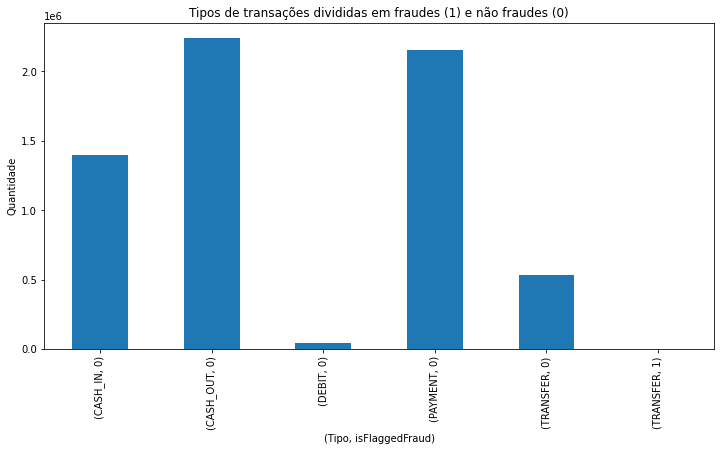

In [ ]:
fig, axes = plt.subplots(figsize=(12,6))
fig = df.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
fig.set_title('Tipos de transações divididas em fraudes (1) e não fraudes (0)')
fig.set_xlabel('(Tipo, isFlaggedFraud)')
fig.set_ylabel('Quantidade');

---
**Relacionando isFlaggedFraud com a quantidade de $ envolvida na transação**

---


In [ ]:
dfTransfer = df.loc[df['type'] == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]
dfFlagged.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1


---

**O balanço inicial e final, tanto do destinatário quando do remetente, não se alteram**

Quando o isFlaggedFraud = 1, significa que a transação fraudulenta foi detectada e parou de ser processada, às vezes é por isso que os valores não se alteram


---



In [ ]:
print('Quantidade mínima de uma FlaggedFraud: ', dfFlagged.amount.min())
print('Quantidade máxima de uma FlaggedFraud: ', dfFlagged.amount.max())
print('Quantidade mínima de uma TRANSFERÊNCIA não setada como Flagged: ', dfNotFlagged.amount.min())
print('Quantidade máxima de uma TRANSFERÊNCIA não setada como Flagged: ', dfNotFlagged.amount.max())

Quantidade mínima de uma FlaggedFraud:  353874.22
Quantidade máxima de uma FlaggedFraud:  10000000.0
Quantidade mínima de uma TRANSFERÊNCIA não setada como Flagged:  0.0
Quantidade máxima de uma TRANSFERÊNCIA não setada como Flagged:  92445516.64


---

**Analisar a relação do Balanço inicial e final do destinatário sendo zero com a transação não sendo classificada como flaggedfraud**

Será que todos esses valores são possíveis fraudes?

---

In [ ]:
print(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceDest == 0) & (dfTransfer.newbalanceDest == 0)]))
print(len(df.loc[(df['isFraud'] == 1) & (df['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0) & (df['type'] == 'TRANSFER')]))

4158
4068


---
O resultado total de fraudes por transferência foi de 4097 (dentre esse valor, também tem as flaggedFrauds)

O resultado total de não flaggedFraud (da coluna TRANSFER) e ainda sim o balanço do dest = 0, foi 4158 

Portanto essa condição (old e newbalanceDest = 0) não determina que será flaggedfraud.

Mas é determinante para ser fraude já que 4068 das 4097 fraudes tem  old e newbalanceDest = 0

**Balanço do dest está diretamente ligado com fraude**

---

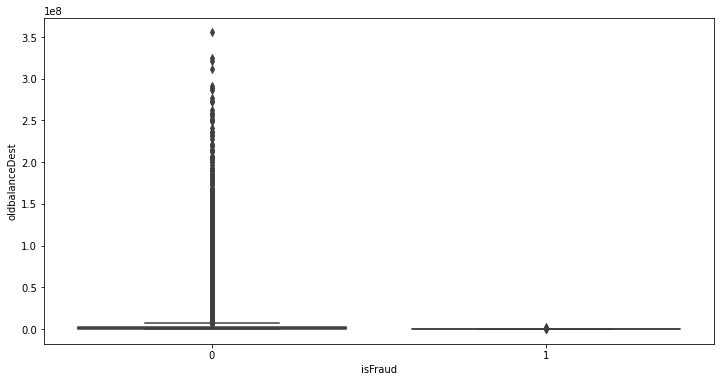

In [ ]:
fig, axes = plt.subplots(figsize=(12,6))
tmp = df.loc[(df.type == 'TRANSFER')]
sns.boxplot(x = 'isFraud', y = 'oldbalanceDest', data = tmp);

**Analisar se o antigo balanço do remetente influencia**  

---

In [ ]:
print("Quantidade minima do oldbalanceOrig quando isFlaggedFraud", dfFlagged.oldbalanceOrg.min()) 
print("Quantidade máxima do oldbalanceOrig quando isFlaggedFraud", dfFlagged.oldbalanceOrg.max()) 
print("Quantidade minima do oldbalanceOrig quando não é setada como fraude", dfNotFlagged.oldbalanceOrg.min()) 
print("Quantidade máxima do oldbalanceOrig quando não é setada como fraude", dfNotFlagged.oldbalanceOrg.max()) 

Quantidade minima do oldbalanceOrig quando isFlaggedFraud 353874.22
Quantidade máxima do oldbalanceOrig quando isFlaggedFraud 19585040.37
Quantidade minima do oldbalanceOrig quando não é setada como fraude 0.0
Quantidade máxima do oldbalanceOrig quando não é setada como fraude 59585040.37


---
**Será que os destinatários e remetentes marcados como flaggedFraud realizaram outras transações que não foram marcadas?**

---

In [ ]:
print("Algum nameOrig marcado como Flaggedfraud participou de mais alguma transação?", dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, dfNotFlagged.nameDest])).any())
print("Algum nameDest marcado como Flaggedfraud participou de mais alguma transação?", dfFlagged.nameDest.isin(pd.concat([dfNotFlagged.nameDest, dfNotFlagged.nameOrig])).any())

Algum nameOrig marcado como Flaggedfraud participou de mais alguma transação? False
Algum nameDest marcado como Flaggedfraud participou de mais alguma transação? True


Existe(m) nameDest que participou de outras transações, checar se foi como Destinatario, Origem e a quantidade de vezes que participou

In [ ]:
print("Algum nameDest marcado como Flaggedfraud participou de mais alguma transação?", dfFlagged.nameDest.isin(dfNotFlagged.nameDest).any())

Algum nameDest marcado como Flaggedfraud participou de mais alguma transação? True


Foi destinatário mais de uma vez (Quantas?)




In [ ]:
print(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest)))

2


Apenas 2 das 16 flaggedfrauds foram destinadas para a mesma pessoa

---
**Descartar a coluna de flaggedFraud, visto que todas as vezes que ela ocorre é realmente fraude, e a quantidade que ela detecta é minuscula**

---


---
**Analisar se existem labels fraudulentas em comum no CASH_OUT e TRANSFER** 

Para que tenha label em comum, é necessário transferir o dinheiro e depois sacar (o contrário obviamente não é possível)

---

In [ ]:
dfFraudTransfer = df.loc[(df['isFraud'] == 1) & (df['type'] == 'TRANSFER')]
dfFraudCashOut = df.loc[(df['isFraud'] == 1) & (df['type'] == 'CASH_OUT')]

In [ ]:
print(dfFraudTransfer.nameDest.isin(dfFraudCashOut.nameOrig).any())

False


---
**Analisar se existem labels fraudulentas de transferência que podem originar cash out e não são detectadas como fraudulentas**

---

In [ ]:
print(dfFraudTransfer.nameDest.isin(df.loc[(df['isFraud'] == 0) & (df['type'] == 'CASH_OUT')].nameOrig).any())

True


In [ ]:
labels = (dfFraudTransfer.loc[dfFraudTransfer.nameDest.isin(df.loc[(df['isFraud'] == 0) & (df['type'] == 'CASH_OUT')].nameOrig)])
labels

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1030443,65,TRANSFER,1282971.57,C1175896731,1282971.57,0.0,C1714931087,0.0,0.0,1,0
6039814,486,TRANSFER,214793.32,C2140495649,214793.32,0.0,C423543548,0.0,0.0,1,0
6362556,738,TRANSFER,814689.88,C2029041842,814689.88,0.0,C1023330867,0.0,0.0,1,0


---
CASH-IN is the process of increasing the balance of
account by paying in cash to a merchant.

CASH-OUT is the opposite process of CASH-IN, it
means to withdraw cash from a merchant which decreases
the balance of the account

**Verificando se há merchant no nome**

---

In [ ]:
df.loc[(df['type'] == 'CASH_IN') & (df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M'))]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [ ]:
df.loc[(df['type'] == 'CASH_OUT') & (df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M'))]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [ ]:
(df.loc[(df['type'] == 'PAYMENT') & (df.loc[df.type == 'PAYMENT'].nameDest.str.contains('M'))]).head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


Só o PAYMENT que funciona do jeito esperado, então posso descartar os nomes pois ele não estão significando nada

---
**Analisando apenas os tipos CASH_OUT e TRANSFER, onde ocorrem as fraudes**

---

In [ ]:
temp = df.loc[(df['type'].isin(['TRANSFER', 'CASH_OUT']))]
temp.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#fig = temp.type.value_counts().plot(kind='bar', title='Tipo de transação', figsize=(12,6))

df_count = temp.type.value_counts()
df_count = pd.DataFrame(df_count).reset_index()
df_count.columns = ['type', 'amount']
fig = px.bar(df_count, x='type', y='amount',labels={'type':'Tipo de Transação', 'amount':'Quantidade'})
fig.update_layout(title_text='Tipos de Transações',width=700, height=450)

In [ ]:
#fig = pd.value_counts(temp['isFraud']).plot(kind='bar', title='Tipo de transação', figsize=(12,6))
df_count = temp['isFraud'].value_counts()
df_count = pd.DataFrame(df_count).reset_index()
df_count.columns = ['type', 'amount']
fig = px.bar(df_count, x='type', y='amount',labels={'type':'Fraude (0) vs Não Fraude (1)', 'amount':'Quantidade'})
fig.update_layout(title_text='Tipos de Transações',width=700, height=450)

---
**Mesmo reduzindo o dataset para apenas esses dois tipos de transações, ainda fica desbalanceado**

---

In [ ]:
print("Porcentagem de fraudes nesse conjunto reduzido:{:.3f}%" .format((len(temp[temp.isFraud==1])/len(temp)*100)))

Porcentagem de fraudes nesse conjunto reduzido:0.296%


# Modelagem

---
**Através da AED, tenho que as fraudes só ocorrem em TRANSFER E CASH_OUT**

---


In [ ]:
temp.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [ ]:
X = temp.drop(['isFraud', 'type'], axis=1)
y = temp['isFraud']

In [ ]:
tp = pd.get_dummies(temp['type'], drop_first=True)

In [ ]:
X = pd.concat([X, tp], axis = 1)
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1
3,1,181.00,181.0,0.0,21182.0,0.00,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,215310.30,705.0,0.0,22425.0,0.00,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,1


---
**Balanceando o conjunto de dados**

---

In [ ]:
# summarize class distribution
counter = Counter(y)
print("Tamanho original do dataset:", counter)

Tamanho original do dataset: Counter({0: 2762196, 1: 8213})


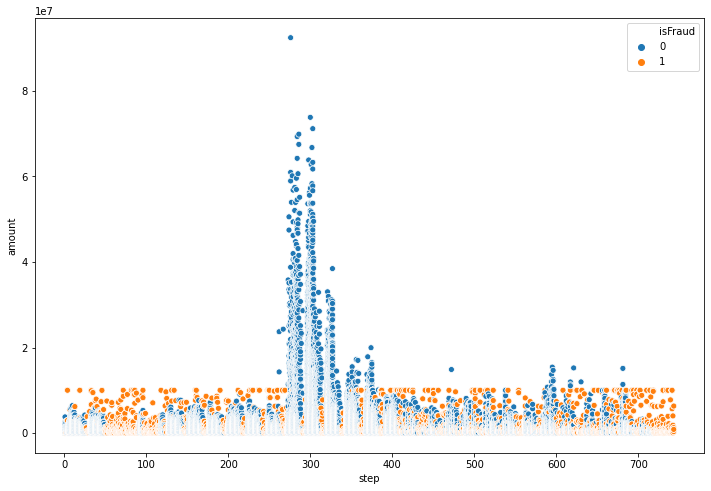

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="step", y="amount", hue= y, data=X);

In [ ]:
print('Tamanho de X:', X.shape)
print('Tamanho de y:', y.shape)

Tamanho de X: (2770409, 7)
Tamanho de y: (2770409,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_copy = X_train
y_train_copy = y_train

In [ ]:
print('Tamanho do X_train, y_train, X_test, y_test:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Tamanho do X_train, y_train, X_test, y_test: (1939286, 7) (1939286,) (831123, 7) (831123,)


In [ ]:
print('Antes do balanceamento: \nQuantidade de labels fraudulentas:', sum(y_train == 1), '\nQuantidade de labels não fraudulentas:', sum(y_train == 0))

Antes do balanceamento: 
Quantidade de labels fraudulentas: 5717 
Quantidade de labels não fraudulentas: 1933569


---
**Aplicando o SMOTE**

---

In [ ]:
sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [ ]:
X_train_sm = pd.DataFrame(X_train_sm)
X_train_sm.rename(columns={0: 'step', 1: 'amount', 2: 'oldbalanceOrg', 3:'newbalanceOrig', 4:'oldbalanceDest',
                           5:'newbalanceDest', 6:'TRANSFER'}, inplace=True)

In [ ]:
print('Depois do balanceamento: \nQuantidade de labels fraudulentas:', sum(y_train_sm == 1), '\nQuantidade de labels não fraudulentas:', sum(y_train_sm == 0))

Depois do balanceamento: 
Quantidade de labels fraudulentas: 1933569 
Quantidade de labels não fraudulentas: 1933569


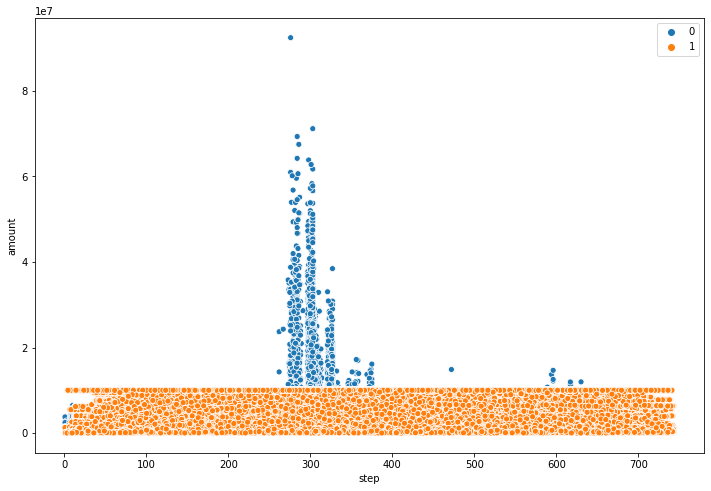

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="step", y="amount", hue= y_train_sm, data=X_train_sm);

---
**Combinando SMOTE com Under-Sampling**

---

In [ ]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_copy_sm, y_train_copy_sm = pipeline.fit_resample(X_train_copy, y_train_copy)

In [ ]:
X_train_copy_sm = pd.DataFrame(X_train_copy_sm)
X_train_copy_sm.rename(columns={0: 'step', 1: 'amount', 2: 'oldbalanceOrg', 3:'newbalanceOrig', 4:'oldbalanceDest',
                           5:'newbalanceDest', 6:'TRANSFER'}, inplace=True)

In [ ]:
print('Depois do balanceamento SMOTE com Under-Sampling: \nQuantidade de labels fraudulentas:', sum(y_train_copy_sm == 1), '\nQuantidade de labels não fraudulentas:', sum(y_train_copy_sm == 0))

Depois do balanceamento SMOTE com Under-Sampling: 
Quantidade de labels fraudulentas: 193356 
Quantidade de labels não fraudulentas: 386712


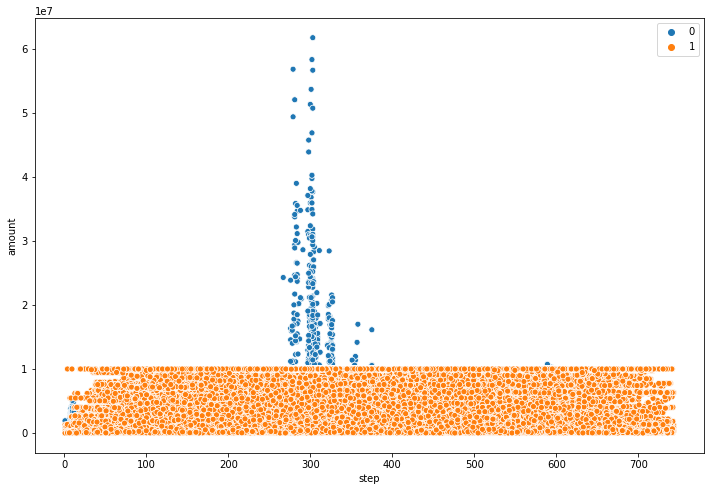

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='step', y='amount', hue= y_train_copy_sm, data=X_train_copy_sm)

In [ ]:
#plt.figure(figsize=(12, 8))
#for label, _ in counter.items():
#	row_ix = np.where(y_train_copy_sm == label)[0]
#	plt.scatter(X_train_copy_sm[row_ix, 0], X_train_copy_sm[row_ix, 1], label=str(label), alpha=0.5)
#plt.legend()
#plt.show()

# Processamento
---
Testes com:

**1.**  Naive Bayes

**2.** Logistic Regression

**3.**  Random Forest

**4.**  Light GBM

**5.**  XGBoost
6.  Support Vector Machine (Demorou muito)
7.  KNN (Demorou muito)

---

In [ ]:
class Classificacao:
  def __init__(self, classif, model_name):
    self.name = model_name
    self.classifier = classif

  def norm_under(self, normalizar, under):
    if normalizar & under:
      steps = [('Norma', StandardScaler()), ('over', SMOTE(sampling_strategy=0.1)), 
               ('under', RandomUnderSampler(sampling_strategy=0.5)), ('Class', self.classifier)]
    elif normalizar:
       steps = [('Norma', StandardScaler()), ('over', SMOTE()), ('Class', self.classifier)]
    elif under:
      steps = [('over', SMOTE(sampling_strategy=0.1)), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('Class', self.classifier)]
    else:
      steps = [('over', SMOTE()), ('Class', self.classifier)]
    return steps

  def holdout(self, normalizar=False, under=False):
    global X_train, y_train, X_test, y_test

    steps = self.norm_under(normalizar, under)
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train.values, y_train)
    pred = pipeline.predict(X_test.values)
    print('Acuracia do {}: {}' .format(self.name, accuracy_score(y_test, pred)))
    print('Média da curva ROC_AUC do {}: {}' .format(self.name, mean(roc_auc_score(y_test, pred))))
    print('F1 score do {}: {}' .format(self.name, f1_score(y_test, pred, average='macro')))
    return pred

  def crossvalidation(self, normalizar=False, under=False):
    global X_train, y_train, X_test, y_test

    steps = self.norm_under(normalizar, under)
    pipeline = Pipeline(steps=steps)
    kfold = StratifiedKFold(n_splits=10, random_state=42)
    scorers = {'accuracy_score': make_scorer(accuracy_score),
              'roc_auc_score': make_scorer(roc_auc_score),
              'f1_score': make_scorer(f1_score, average='macro')
              }
    resultado = cross_validate(pipeline, X_train, y_train, scoring=scorers, cv=kfold)
    for name in resultado.keys():
      media_scorers = np.average(resultado[name])
      print('{} do {}: {}' .format(name, self.name, media_scorers))
    pipeline.fit(X_train.values, y_train)

def print_auc_graf(results):
  global y_test

  plt.figure(figsize=(12, 8))
  ns_probs = [0 for _ in range(len(y_test))]
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  plt.plot(ns_fpr, ns_tpr, linestyle='--')

  for name, pred_r in results.items():
    fpr, tpr, _ = roc_curve(y_test, pred_r)
    plt.plot(fpr, tpr, marker='.', label= "CURVA ROC AUC {} = {:.3f}" .format(name, roc_auc_score(y_test, pred_r)))
  plt.title("CURVA ROC_AUC HOLDOUT")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

## Holdout

In [ ]:
nb = Classificacao(GaussianNB(), 'NB')
result_nb = nb.holdout(False, False)

Acuracia do NB: 0.9772813410289451
Média da curva ROC_AUC do NB: 0.7173906251987184
F1 score do NB: 0.5480329112955353


In [ ]:
lr = Classificacao(LogisticRegression(), 'LR')
result_lr = lr.holdout(True, False)

Acuracia do LR: 0.9402206412287952
Média da curva ROC_AUC do LR: 0.9242850695220945
F1 score do LR: 0.5263639461678001


In [ ]:
rf = Classificacao(RandomForestClassifier(), 'RF')
result_rf = rf.holdout(True, False)

Acuracia do RF: 0.9983805044500031
Média da curva ROC_AUC do RF: 0.9776183657516497
F1 score do RF: 0.8896622344935637


In [ ]:
lightgbm = Classificacao(LGBMClassifier(), 'LGB')
result_lgb = lightgbm.holdout(True, False)

Acuracia do LGB: 0.9923669541090789
Média da curva ROC_AUC do LGB: 0.9931762243039945
F1 score do LGB: 0.7175196751094897


In [ ]:
xg = Classificacao(XGBClassifier(), 'XGB')
result_xg = xg.holdout(True, False)

Acuracia do XGB: 0.9762562220032414
Média da curva ROC_AUC do XGB: 0.984297725362604
F1 score do XGB: 0.5943067097367848


## Cross-Validation

In [ ]:
nb.crossvalidation(True, False)

fit_time do NB: 10.833898091316223
score_time do NB: 0.16118874549865722
test_accuracy_score do NB: 0.9768858233438962
test_roc_auc_score do NB: 0.7292465238988
test_f1_score do NB: 0.5487228022080397


In [ ]:
lr.crossvalidation(True, False)

fit_time do LR: 26.415639138221742
score_time do LR: 0.17858760356903075
test_accuracy_score do LR: 0.941776506913415
test_roc_auc_score do LR: 0.9225804528032071
test_f1_score do LR: 0.5269252357401135


In [ ]:
rf.crossvalidation(True, True)

fit_time do RF: 111.34270892143249
score_time do RF: 2.1703593254089357
test_accuracy_score do RF: 0.9969849728884762
test_roc_auc_score do RF: 0.9811348920323161
test_f1_score do RF: 0.8261875681719555


In [ ]:
lightgbm.crossvalidation(True, False)

fit_time do LGB: 51.4823855638504
score_time do LGB: 1.2018569231033325
test_accuracy_score do LGB: 0.992491050861376
test_roc_auc_score do LGB: 0.992135890229544
test_f1_score do LGB: 0.7171069877604515


In [ ]:
xg.crossvalidation(False, False)

ValueError: ignored

In [ ]:
x=XGBClassifier()

pipeline = Pipeline(steps=[ ('Class', x)])
kfold = StratifiedKFold(n_splits=10, random_state=42)
scorers = {'accuracy_score': make_scorer(accuracy_score),
          'roc_auc_score': make_scorer(roc_auc_score),
          'f1_score': make_scorer(f1_score, average='macro')
          }

resultado = cross_validate(pipeline, X_train, y_train, scoring=scorers, cv=kfold)
for name in resultado.keys():
  media_scorers = np.average(resultado[name])
  print('{} do: {}' .format(name, media_scorers))

## Visualização das curvas ROC_AUC

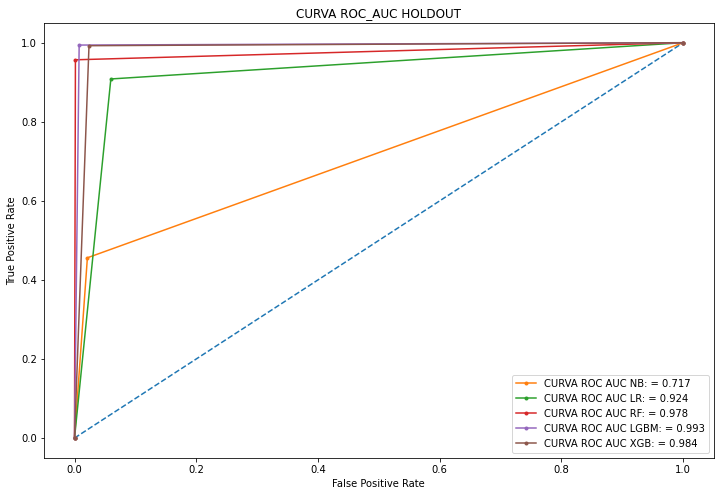

In [ ]:
results = {"NB:": result_nb, "LR:": result_lr, 
           "RF:": result_rf, "LGBM:": result_lgb, "XGB:": result_xg}
print_auc_graf(results)